__Author:__ Bogdan Bintu

__Email:__ bbintu@g.harvard.edu

__Date:__ 3/4/2020



#### Note: This assumes Python 2

In [1]:
# Imports
import numpy as np
import glob,os,sys
import matplotlib.pylab as plt

import workers #worker package to parallelize

#Warning: Installing ipyparallel is recomended

In [6]:
######### Get the info for the current project
master_folder=r'\\dolly\Raw_data\Bogdan\8_26_2019__IMR90_6hAmanitin_STORM65'
hfolders = [folder for folder in glob.glob(master_folder+os.sep+'*')
           if os.path.isdir(folder) and glob.glob(folder+os.sep+'*.dax')>0 and os.path.basename(folder)[0]!='F']
hinds = [workers.getH(hfolder) for hfolder in hfolders]
hfolders = np.array(hfolders)[np.argsort(hinds)]
fovs = map(os.path.basename,glob.glob(hfolders[0]+os.sep+'*.dax'))
analysis_folder = master_folder+'-Analysis'
if not os.path.exists(analysis_folder): os.makedirs(analysis_folder)

In [7]:
hfolders

array(['\\\\dolly\\Raw_data\\Bogdan\\8_26_2019__IMR90_6hAmanitin_STORM65\\A1Geminin',
       '\\\\dolly\\Raw_data\\Bogdan\\8_26_2019__IMR90_6hAmanitin_STORM65\\A2SC35',
       '\\\\dolly\\Raw_data\\Bogdan\\8_26_2019__IMR90_6hAmanitin_STORM65\\A3Nucleolus',
       '\\\\dolly\\Raw_data\\Bogdan\\8_26_2019__IMR90_6hAmanitin_STORM65\\H20B,B',
       '\\\\dolly\\Raw_data\\Bogdan\\8_26_2019__IMR90_6hAmanitin_STORM65\\H58R1,R26',
       '\\\\dolly\\Raw_data\\Bogdan\\8_26_2019__IMR90_6hAmanitin_STORM65\\H59R2,R27',
       '\\\\dolly\\Raw_data\\Bogdan\\8_26_2019__IMR90_6hAmanitin_STORM65\\H60R3,R28',
       '\\\\dolly\\Raw_data\\Bogdan\\8_26_2019__IMR90_6hAmanitin_STORM65\\H61R4,R29',
       '\\\\dolly\\Raw_data\\Bogdan\\8_26_2019__IMR90_6hAmanitin_STORM65\\H62R5,R30',
       '\\\\dolly\\Raw_data\\Bogdan\\8_26_2019__IMR90_6hAmanitin_STORM65\\H63R6,R31',
       '\\\\dolly\\Raw_data\\Bogdan\\8_26_2019__IMR90_6hAmanitin_STORM65\\H64R7,R32',
       '\\\\dolly\\Raw_data\\Bogdan\\8_26_2019__IMR90_6hAm

In [9]:
######### compute the median value across all fields of view - this helps flatten the illumination
num_cols,remove_first = 4,0
hfolder = hfolders[10]
print hfolder
meds_fl = analysis_folder+os.sep+'im_meds.npy'
if not os.path.exists(meds_fl):
    im_meds = [np.mean([workers.get_frame(hfolder+os.sep+fov,ind_z=ind_col+remove_first) for fov in fovs],axis=0) 
               for ind_col in range(num_cols)]
    np.save(meds_fl,np.array(im_meds,dtype=np.float32))

\\dolly\Raw_data\Bogdan\8_26_2019__IMR90_6hAmanitin_STORM65\H112B,R3,R5


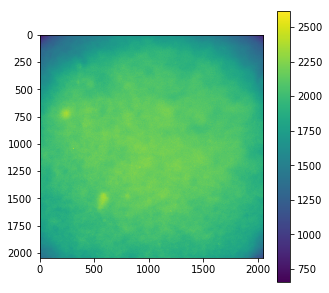

In [21]:
#### check illumination profile
im_med = np.load(meds_fl)
plt.figure(figsize=(5,5))
im = im_med[3]
plt.imshow(im,vmax=np.percentile(im,95)*1.2)
plt.colorbar()

In [22]:
# Organize the paramaters across all the field of views and conditions
def ref_fl(dax_fl,ref_tags = ['H20B,B','H20B,B']):
    htag = os.path.basename(os.path.dirname(dax_fl))
    fov = os.path.basename(dax_fl)
    ref_tag = ref_tags[-1] if 'Q' in htag else ref_tags[0]
    ref_hfolder = [hfolder for hfolder in hfolders if ref_tag in os.path.basename(hfolder)][0]
    dax_fl_ref = ref_hfolder+os.sep+fov
    return dax_fl_ref
paramaters = []
overwrite_fits,overwrite_drift=False,False
for fovind in range(len(fovs)):
    for hind in range(len(hfolders)):
        htag = os.path.basename(hfolders[hind])
        dax_fl = hfolders[hind]+os.sep+fovs[fovind]
        ref_dax_fl = ref_fl(dax_fl)
        paramaters.append((dax_fl,ref_dax_fl,overwrite_fits,overwrite_drift))
print len(paramaters)

4270


In [24]:
#Run the workers in parallel to perform rough registration and fit the beads in the data.
# while workers can also perform rough (yet fast) fitting of the signal data, 
#this is mostly used for testing as the gaussian fitting is more precise
#Add path to the system to be able to import 

#Open terminal and run: ipcluster start -n 20
import ipyparallel as ipp
from ipyparallel import Client
rc = Client()
import workers
reload(workers)
def f(parm):
    import sys
    sys.path.append(r'E:\Bogdan\Dropbox\code_Seurat\WholeGenome_MERFISH\Analysis_code')
    import workers
    reload(workers)
    
    success = workers.run_fitting_analysis(parm,remove_first=0,im_pad=0,fit_colors=False)
    return success

In [ ]:
res = rc[:].map_sync(f,paramaters[:])

In [ ]:
### Example of single run output 

In [25]:
f(paramaters[3000])

Loading image: \\dolly\Raw_data\Bogdan\8_26_2019__IMR90_6hAmanitin_STORM65\H65R8,R33\Conv_zscan_64.dax
time: 3.11999988556
Dealing with the drift
Loading reference image...
Making file: \\dolly\Raw_data\Bogdan\8_26_2019__IMR90_6hAmanitin_STORM65-Analysis\beads\H20B,B___Conv_zscan_64__reg0.npy
Making file: \\dolly\Raw_data\Bogdan\8_26_2019__IMR90_6hAmanitin_STORM65-Analysis\beads\H20B,B___Conv_zscan_64__reg1.npy
Making file: \\dolly\Raw_data\Bogdan\8_26_2019__IMR90_6hAmanitin_STORM65-Analysis\beads\H20B,B___Conv_zscan_64__reg2.npy
Making file: \\dolly\Raw_data\Bogdan\8_26_2019__IMR90_6hAmanitin_STORM65-Analysis\beads\H20B,B___Conv_zscan_64__reg3.npy
Making file: \\dolly\Raw_data\Bogdan\8_26_2019__IMR90_6hAmanitin_STORM65-Analysis\beads\H20B,B___Conv_zscan_64__reg4.npy
Making file: \\dolly\Raw_data\Bogdan\8_26_2019__IMR90_6hAmanitin_STORM65-Analysis\beads\H20B,B___Conv_zscan_64__reg5.npy
Making file: \\dolly\Raw_data\Bogdan\8_26_2019__IMR90_6hAmanitin_STORM65-Analysis\beads\H20B,B___Conv

Fitting_v4.py:806: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m_ = [np.linalg.lstsq(A, y_[:,iy])[0] for iy in range(len(x_[0]))]


True